# Meditations on `discr`

In [1]:
# Imports
%load_ext lab_black
from itertools import product, chain, combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pingouin import intraclass_corr
import random
from scipy.spatial.distance import (
    pdist,
    squareform,
    correlation as distance_correlation,
)
from scipy.special import expit
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from tqdm.auto import tqdm
import warnings

pd.set_option("display.precision", 3)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def make_data(
    n_subjects=5,
    n_replicates=2,
    n_dimensions=1,
    offset=0,
    noise=0,
    gain=1,
    n_outliers=0,
):
    """Generic function to make clustered data (resembling Figure 1 data)"""

    # Make perfect data (every replicate is identical within-subject)
    data = pd.DataFrame(
        chain(*[[i] * n_replicates for i in range(n_subjects)]),
        index=pd.MultiIndex.from_product(
            [range(n_subjects), range(n_replicates)], names=["Subject", "Replicate"]
        ),
        columns=["Dim%d" % dim for dim in range(n_dimensions)],
    )

    # Multiply by this factor
    data *= gain
    # Add this amount of noise
    data += noise * np.random.randn(n_subjects * n_replicates, n_dimensions)
    # Make replicates span a certain range (within-subject)
    data = data.add(
        data.index.get_level_values("Replicate") * offset / (n_replicates - 1), axis=0
    )
    # Select some points to be outliers
    if n_outliers:
        for subject in random.sample(range(n_subjects), n_outliers):
            data.loc[(subject, 0)] += 10
    return data


# Show example data
data = make_data(offset=0.25, noise=0.5)
data.head()

Dim0
Subject Replicate       
0       0         -0.365
        1          0.286
1       0          1.333
        1          1.833
2       0          2.216

In [3]:
def make_dist(data=None, metric="euclidean", **kwargs):
    """Generic function to make a distance matrix, including making the data matrix if needed"""
    if data is None:
        data = make_data(**kwargs)
    dist = pd.DataFrame(index=data.index, columns=data.index)
    dist[:] = squareform(pdist(data, metric=metric))
    return dist


dist = make_dist(data)
dist.head()

Subject                0             1             2             3         \
Replicate              0      1      0      1      0      1      0      1   
Subject Replicate                                                           
0       0          0.000  0.651  1.698  2.198  2.581  2.167  3.561  3.500   
        1          0.651  0.000  1.048  1.547  1.930  1.516  2.910  2.850   
1       0          1.698  1.048  0.000  0.499  0.882  0.469  1.862  1.802   
        1          2.198  1.547  0.499  0.000  0.383  0.031  1.363  1.302   
2       0          2.581  1.930  0.882  0.383  0.000  0.414  0.980  0.920   

Subject                4         
Replicate              0      1  
Subject Replicate                
0       0          3.940  4.835  
        1          3.289  4.185  
1       0          2.242  3.137  
        1          1.742  2.638  
2       0          1.359  2.255

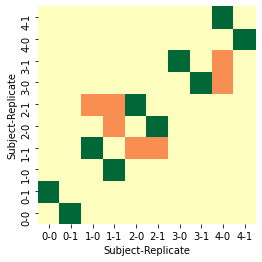

In [4]:
def is_color(col, color):
    """Return a boolean matrix which is True for every cell that should have color `color`.
    Orange distances are those closer than the green cell(s) in the same column."""
    assert color in ["green", "orange"]
    subject, replicate = col.name
    if color == "green":
        result = (col.index.get_level_values(0) == subject) & (
            col.index.get_level_values(1) != replicate
        )
    elif color == "orange":
        green_mean = col[is_color(col, "green")].mean()
        result = (col.index.get_level_values(0) != subject) & (col < green_mean)
    return result


def style(col, color="green"):
    """Style a Pandas dataframe with `color`, where it applies"""
    z = is_color(col, color)
    return ["background-color: %s" % color if x else "" for x in z]


def color_fig(dist, ax=None):
    """Make a heatmap of the distance matrix, colored as in the paper"""
    green_orange = dist.apply(is_color, color="green").astype(int) - 0.5 * dist.apply(
        is_color, color="orange"
    )
    ax = sns.heatmap(
        green_orange, cmap="RdYlGn", vmin=-1, vmax=1, cbar=False, ax=ax, square=True
    )
    ax.invert_yaxis()
    return ax


# Graphical version
color_fig(dist)

# Pandas version
dist.style.apply(style, color="green").apply(style, color="orange")

In [5]:
def discr(dist):
    """Implementation of the `discr` measure"""
    assert all(np.diag(dist) == 0)  # A distance matrix must have a 0 diagonal
    g = dist.apply(is_color, color="green").sum().sum()
    f = dist.apply(is_color, color="orange").sum().sum()
    N = dist.shape[0]
    return 1 - f / (N ** 2 - g)


def picc(data):
    """Implementation of the `PICC` measure (ICC on PC1)"""
    pca = pd.DataFrame(PCA(1).fit_transform(data), index=data.index)
    pca += 1e-4 * np.random.randn(*pca.shape)  # For numerical stability
    result = intraclass_corr(
        pca.reset_index(),
        raters="Replicate",
        ratings=0,
        targets="Subject",
        nan_policy="omit",
    )
    return result.set_index("Type")["ICC"]["ICC2"]


def dcorr(data):
    """Implementation of distance correlation, specific to the data format we are using"""
    assert len(data.index.levels[0] == 2)  # Exactly two replicates
    pca = pd.DataFrame(PCA(1).fit_transform(data), index=data.index)
    # pca += 1e-4 * np.random.randn(*pca.shape)  # For numerical stability
    u = pca.xs(0, level="Replicate").values
    v = pca.xs(1, level="Replicate").values
    return 1 - distance_correlation(u, v)


def _d2(means, covs, s1, s2):
    """Helper function for calculating the multivariate D' for a single pair of subjects"""
    pooled_cov = (covs.loc[s1] + covs.loc[s2]) / 2
    diff = means.loc[s1] - means.loc[s2]
    return diff.T @ np.linalg.inv(pooled_cov) @ diff


def d2s(data, n_pcs=None):
    """Implementaiton of the multivariate D' for all pairs of subjects.
    Returns a series of D2 values, one for each unique subject pair"""
    subjects = list(data.index.levels[0])
    subject_pairs = list(combinations(list(subjects), 2))
    d2 = pd.Series(index=subject_pairs, dtype="float")
    if n_pcs:
        pca = PCA(n_pcs)
        df = pd.DataFrame(pca.fit_transform(data), index=df.index)
    means = data.groupby("Subject").mean()
    covs = data.groupby("Subject").cov()
    for s1, s2 in subject_pairs:
        d2[(s1, s2)] = _d2(means, covs, s1, s2)
    return d2


def ultimo(data):
    """Reduces D2 to a scalar in the range [0, 1].
    expit is the inverse of logit."""
    return expit(d2s(data)).median()


# Compute `discr` and `ultimo` on the current data and distance matrix
print("Discr=%.3g" % discr(dist))
print("Ultimo=%.3g" % ultimo(data))

Discr=0.922
Ultimo=1


### Figure 1

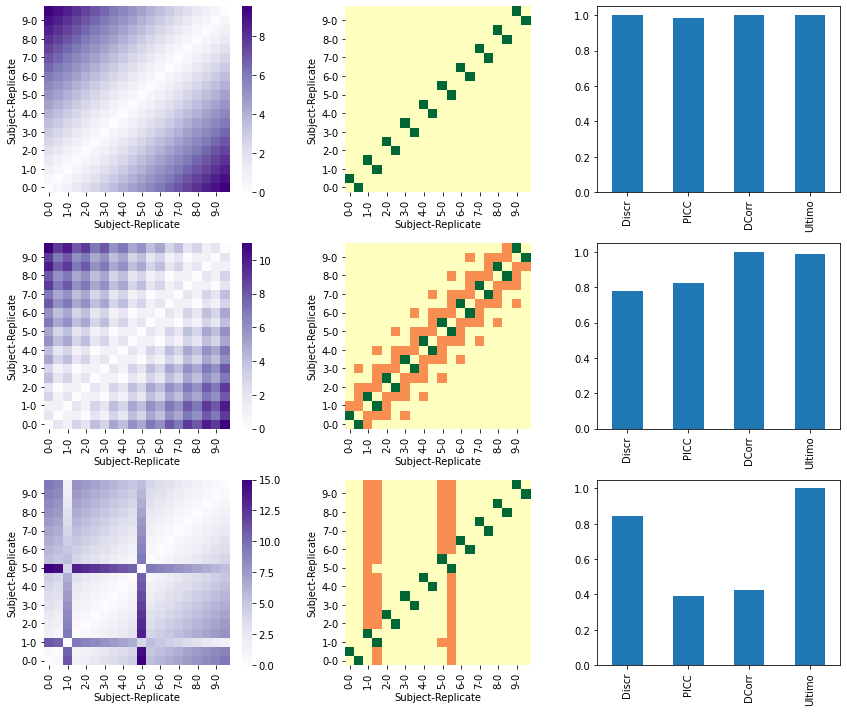

In [6]:
# Pseudo-replication of Figure 1

# (name, offset, n_outlers) tuples for each of the three rows of panels
conditions = [("Discriminable", 0.5, 0), ("Offset", 2, 0), ("Outlier", 0.5, 2)]

fig, ax = plt.subplots(len(conditions), 3, figsize=(12, 10))
for i, (name, offset, n_outliers) in enumerate(conditions):
    data = make_data(n_subjects=10, offset=offset, n_outliers=n_outliers)
    dist = make_dist(data)

    # Left panel
    sns.heatmap(dist, ax=ax[i, 0], cmap="Purples", vmin=0, square=True)
    ax[i, 0].invert_yaxis()

    # Middle panel
    color_fig(dist, ax=ax[i, 1])

    # Right panel
    result = pd.Series(
        [discr(dist), picc(data), dcorr(data), ultimo(data)],
        index=["Discr", "PICC", "DCorr", "Ultimo"],
    )
    result.plot.bar(ax=ax[i, 2])
plt.tight_layout()

### Figure 2

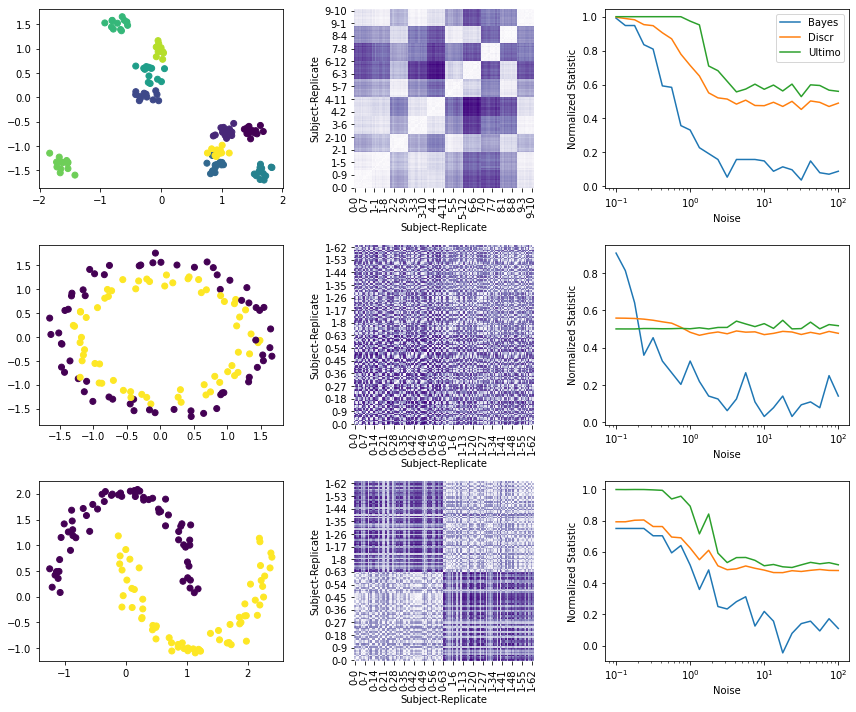

In [7]:
# Pseudo-replication of Figure 2

# The value used in the paper
n_samples = 128

# (Data-generating-function, details) tuples, one for each row of figure panels
conditions = [
    (make_blobs, {"cluster_std": 0, "n_features": 2, "centers": 10}),
    (make_circles, {}),
    (make_moons, {}),
]

fig, ax = plt.subplots(len(conditions), 3, figsize=(4 * len(conditions), 10))
for i, (func, kwargs) in enumerate(conditions):
    # log-spaced values of noise from 0.01 to 10
    noises = np.logspace(-1, 2, 25)
    bayes_accuracy = []
    discrs = []
    ultimos = []
    piccs = []
    dcorrs = []
    for noise in tqdm(noises):
        # Generate the clean data
        X, y = func(n_samples=n_samples, **kwargs)
        # Scale to unit variance in each dimension
        X /= X.std(axis=0)
        # Add the noise (add variance)
        X += noise * np.random.randn(*X.shape)

        # Make a dataframe
        data = pd.DataFrame(
            X,
            index=pd.MultiIndex.from_arrays(
                [y, range(X.shape[0])], names=["Subject", "Replicate"]
            ),
        )
        # Sort it for visualization
        data = data.sort_index()
        # Renumber replicates
        data = data.reset_index(level="Replicate")
        subjects = data.index.unique()
        for subject in subjects:
            data.loc[subject, "Replicate"] = range(data.loc[subject].shape[0])
        data = data.reset_index().set_index(["Subject", "Replicate"])

        dist = make_dist(data)
        # Use a low noise level for the left and middle panels
        if noise == 0.1:
            # Plot the left panels
            ax[i, 0].scatter(*X.T, c=y)
            # Plot the middle panels
            sns.heatmap(
                dist, ax=ax[i, 1], cmap="Purples", vmin=0, square=True, cbar=False
            )
            ax[i, 1].invert_yaxis()
        # Compute the various measures
        # 0.5 is chance so this normalizes between 0-1 for Bayes
        bayes_acc = GaussianNB().fit(X, y).score(X, y)
        chance = 1 / len(subjects)
        bayes_acc = (bayes_acc - chance) / (1 - chance)
        bayes_accuracy.append(bayes_acc)
        discrs.append(discr(dist))
        ultimos.append(ultimo(data))
        piccs.append(picc(data))
        dcorrs.append(dcorr(data))
        # Log-scale for clarity
        ax[i, 2].set_xscale("log")
        ax[i, 2].set_ylabel("Normalized Statistic")
    # Plot the right panels
    ax[i, 2].plot(noises, bayes_accuracy, label="Bayes")
    ax[i, 2].plot(noises, discrs, label="Discr")
    ax[i, 2].plot(noises, ultimos, label="Ultimo")
    ax[i, 2].set_xlabel("Noise")
ax[0, 2].legend()
plt.tight_layout()